# Машинное обучение
## Домашнее задание №1: KNN + Линейные модели

**Срок сдачи:** 10 октября 2023, 23:59

**Максимально баллов:** 10

**Штраф за опоздание:** по 2 балла за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла. Формат сдачи будет указан чуть позже.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -1 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 баллов

При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст, если явно не указана такая возможность.

## KNN (5 баллов)

In [15]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
import sklearn.datasets
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold
from sklearn.neighbors import KNeighborsClassifier, KDTree
from sklearn.metrics import accuracy_score, f1_score
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой.
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [16]:
class MyKNeighborsClassifier(BaseEstimator):

    def __init__(self, n_neighbors, algorithm='brute'):
        self.k = n_neighbors
        self.alg = algorithm

    def fit(self, X, y):
      self.x = np.copy(X)
      self.y = np.copy(y)

    def predict(self, X):
      y_pred = []
      if self.alg == 'brute':
        for j in X:
          dist = np.sqrt(((self.x - j) ** 2).sum(axis=1))
          index = np.argsort(dist)[:self.k]
          values, counts = np.unique(self.y[index], return_counts=True)
          y_pred.append(values[np.argmax(counts)])
      elif self.alg == 'kd_tree':
        for j in X:
          space = np.vstack((self.x, j))
          tree = KDTree(space, leaf_size=7)
          dist, index = tree.query(space, k=self.k + 1)
          index = index[:, 1:]
          index = index[-1]
          values, counts = np.unique(self.y[index], return_counts=True)
          y_pred.append(values[np.argmax(counts)])
      return y_pred


**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [17]:
iris = datasets.load_iris()

In [18]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [19]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [20]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [21]:
my_clf_pred = my_clf.predict(X_test)
accuracy_score(y_test, my_clf_pred)

1.0

In [22]:
sklearn_pred = clf.predict(X_test)
accuracy_score(y_test, sklearn_pred )

1.0

In [23]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза.
Для этого используем numpy.

In [24]:
%timeit clf.fit(X_train, y_train)

376 µs ± 47.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [25]:
%timeit my_clf.fit(X_train, y_train)

2.96 µs ± 852 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [26]:
%timeit clf.predict(X_test)

3.38 ms ± 1.63 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [27]:
%timeit my_clf.predict(X_test)

757 µs ± 23 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Таким образом, можно сделать вывод, что brute force KNN классификатор оправдал ожидания и в плане времени, и в плане метрики качества accuracy

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза.
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn.

In [28]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [29]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [30]:
%time clf.fit(X_train, y_train)

CPU times: user 1.31 ms, sys: 14 µs, total: 1.32 ms
Wall time: 1.33 ms


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [31]:
%time my_clf.fit(X_train, y_train)

CPU times: user 1.11 ms, sys: 0 ns, total: 1.11 ms
Wall time: 1.56 ms


In [32]:
%time
clf.predict(X_test)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs


array([1, 1, 1, 2, 2, 2, 0, 2, 1, 1, 0, 2, 0, 0, 0])

In [33]:
%time
my_clf.predict(X_test)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


[1, 1, 1, 2, 2, 2, 0, 2, 1, 1, 0, 2, 0, 0, 0]

In [34]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

Таким образом, можно сделать вывод, что kdtree KNN классификатор оправдал ожидания и в плане времени, и в плане метрики качества accuracy

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [35]:
newsgroups = sklearn.datasets.fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [36]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [37]:
stop_words = nltk.corpus.stopwords.words()

In [38]:
vectorizer = CountVectorizer(
    ngram_range=(1, 10),
    stop_words=stop_words,
    max_features=1100)
x_cv = vectorizer.fit_transform(data).toarray()

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aldiz', 'baiknya', 'baizik', 'berkali', 'bukatzeko', 'edota', 'eze', 'ezpabere', 'ezpada', 'ezperen', 'gainera', 'gainerontzean', 'guztiz', 'hainbestez', 'horra', 'kali', 'kurangnya', 'mata', 'olah', 'onların', 'ordea', 'osterantzean', 'printr', 'sekurang', 'setidak', 'tama', 'tidaknya', 'δι', 'арбаң', 'арсалаң', 'афташ', 'бай', 'бале', 'баски', 'батыр', 'баҳри', 'болои', 'бүгжең', 'бұтыр', 'валекин', 'вақте', 'вой', 'вуҷуди', 'гар', 'гарчанде', 'далаң', 'даме', 'ербелең', 'жалт', 'жұлт', 'карда', 'кошки', 'куя', 'күңгір', 'кӣ', 'магар', 'майлаш', 'митың', 'модоме', 'нияти', 'онан', 'оре', 'паһ', 'рӯи', 'салаң', 'сар', 'сұлаң', 'сұрт', 'тарбаң', 'тразе', 'ту', 'тыржың', 'тұрс', 'хом', 'хуб', 'чаро', 'чи', 'чун', 'чунон', 'шарте', 'шұңқ', 'ыржың', 'қадар', 'қайқаң', 'қалт', 'қаңғыр', 'қаңқ',

In [39]:
features = np.array(vectorizer.get_feature_names_out())
features

array(['00', '000', '01', ..., 'years ago', 'york', 'young'], dtype=object)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [41]:
kf = KFold(n_splits=3)
for i, (train, test) in enumerate(kf.split(x_cv)):
  print('KFold ', i + 1)
  print('train size ', train[0], ':', train[-1])
  print('test size ', test[0], ':', test[-1])

KFold  1
train size  3772 : 11313
test size  0 : 3771
KFold  2
train size  0 : 11313
test size  3772 : 7542
KFold  3
train size  0 : 7542
test size  7543 : 11313


In [42]:
vectorizer = TfidfVectorizer(
             ngram_range=(1, 15),
             stop_words=stop_words,
              max_features=1000)
x_tf = vectorizer.fit_transform(data).toarray()

In [43]:
features = np.array(vectorizer.get_feature_names_out())
features

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

KNN с косинусной метрикой

In [44]:
clf_cos = KNeighborsClassifier(n_neighbors=6, algorithm='brute', metric='cosine')

KNN с Евклидовой метрикой

In [45]:
clf_euc = KNeighborsClassifier(n_neighbors=6, algorithm='brute')

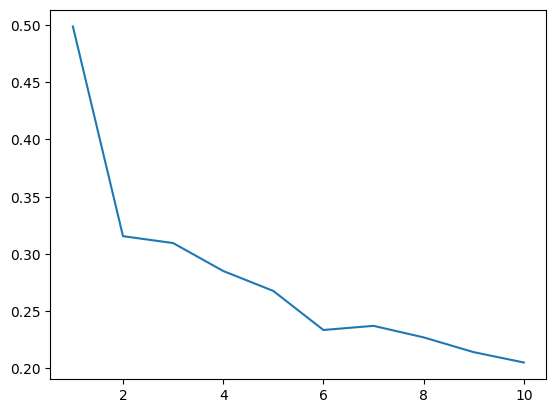

In [46]:
mean_acc = []
for i in range(1, 11):
  clf_euc = KNeighborsClassifier(n_neighbors=i, algorithm='brute')
  total_acc = 0
  for i, (train, test) in enumerate(kf.split(x_tf)):
    clf_euc.fit(x_tf[train[0]:train[-1]], target[train[0]:train[-1]])
    acc = accuracy_score(target[test[0]:test[-1]], clf_euc.predict(x_tf[test[0]:test[-1]]))
    total_acc += acc
  mean_acc.append(total_acc / 3)
plt.plot(np.arange(1, 11), mean_acc)

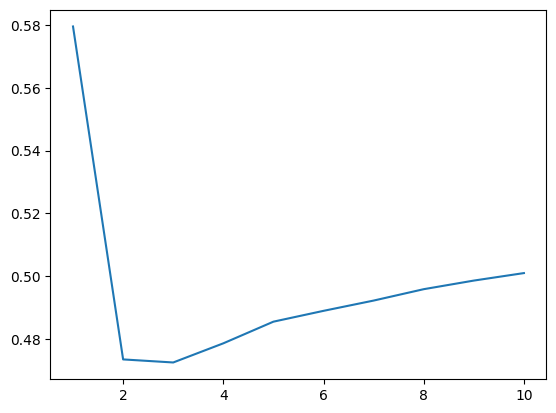

In [47]:
mean_acc = []
for i in range(1, 11):
  clf_cos = KNeighborsClassifier(n_neighbors=i, algorithm='brute', metric='cosine')
  total_acc = 0
  for i, (train, test) in enumerate(kf.split(x_tf)):
    clf_cos.fit(x_tf[train[0]:train[-1]], target[train[0]:train[-1]])
    acc = accuracy_score(target[test[0]:test[-1]], clf_cos.predict(x_tf[test[0]:test[-1]]))
    total_acc += acc
  mean_acc.append(total_acc / 3)
plt.plot(np.arange(1, 11), mean_acc)

In [48]:
mean_acc = []
for i in range(1, 11):
  print('K = ', i)
  clf_euc = KNeighborsClassifier(n_neighbors=i, algorithm='brute')
  total_acc = 0
  for i, (train, test) in enumerate(kf.split(x_tf)):
    # print('KFold ', i + 1)
    clf_euc.fit(x_tf[train[0]:train[-1]], target[train[0]:train[-1]])
    acc = accuracy_score(target[test[0]:test[-1]], clf_euc.predict(x_tf[test[0]:test[-1]]))
    total_acc += acc
    # print('accuracy = ', acc)
    mean_acc.append(total_acc / 3)
  print('mean_accuracy = ', total_acc / 3)

K =  1
mean_accuracy =  0.498738218349773
K =  2
mean_accuracy =  0.31554309131463276
K =  3
mean_accuracy =  0.3095305956551944
K =  4
mean_accuracy =  0.28512692025160136
K =  5
mean_accuracy =  0.26770849526178303
K =  6
mean_accuracy =  0.23357942940693333
K =  7
mean_accuracy =  0.23720428201540866
K =  8
mean_accuracy =  0.22712726210380726
K =  9
mean_accuracy =  0.21421896501313833
K =  10
mean_accuracy =  0.20520147591993532


Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

Кросс-валидация на count vectorizer и KNN(euc)

In [49]:
total_acc = 0
for i, (train, test) in enumerate(kf.split(x_cv)):
  print('KFold ', i + 1)
  clf_euc.fit(x_cv[train[0]:train[-1]], target[train[0]:train[-1]])
  acc = accuracy_score(target[test[0]:test[-1]], clf_euc.predict(x_cv[test[0]:test[-1]]))
  total_acc += acc
  print('accuracy = ', acc)
print('mean_accuracy = ', total_acc / 3)

KFold  1
accuracy =  0.27844073190135243
KFold  2
accuracy =  0.4636604774535809
KFold  3
accuracy =  0.2962864721485411
mean_accuracy =  0.34612922716782474


Кросс-валидация на count vectorizer и KNN(cos)

In [50]:
total_acc = 0
for i, (train, test) in enumerate(kf.split(x_cv)):
  print('KFold ', i + 1)
  clf_cos.fit(x_cv[train[0]:train[-1]], target[train[0]:train[-1]])
  acc = accuracy_score(target[test[0]:test[-1]], clf_cos.predict(x_cv[test[0]:test[-1]]))
  total_acc += acc
  print('accuracy = ', acc)
print('mean_accuracy = ', total_acc / 3)

KFold  1
accuracy =  0.45293025722619995
KFold  2
accuracy =  0.5657824933687002
KFold  3
accuracy =  0.4427055702917772
mean_accuracy =  0.48713944029555917


Кросс-валидация на tf-idf vectorizer и KNN(euc)

In [51]:
total_acc = 0
for i, (train, test) in enumerate(kf.split(x_tf)):
  print('KFold ', i + 1)
  clf_euc.fit(x_tf[train[0]:train[-1]], target[train[0]:train[-1]])
  acc = accuracy_score(target[test[0]:test[-1]], clf_euc.predict(x_tf[test[0]:test[-1]]))
  total_acc += acc
  print('accuracy = ', acc)
print('mean_accuracy = ', total_acc / 3)

KFold  1
accuracy =  0.17130734553168922
KFold  2
accuracy =  0.2830238726790451
KFold  3
accuracy =  0.16127320954907162
mean_accuracy =  0.20520147591993532


Кросс-валидация на tf-idf vectorizer и KNN(cos)

In [52]:
total_acc = 0
for i, (train, test) in enumerate(kf.split(x_tf)):
  print('KFold ', i + 1)
  clf_cos.fit(x_tf[train[0]:train[-1]], target[train[0]:train[-1]])
  acc = accuracy_score(target[test[0]:test[-1]], clf_cos.predict(x_tf[test[0]:test[-1]]))
  total_acc += acc
  print('accuracy = ', acc)
print('mean_accuracy = ', total_acc / 3)

KFold  1
accuracy =  0.454786528772209
KFold  2
accuracy =  0.5883289124668435
KFold  3
accuracy =  0.459946949602122
mean_accuracy =  0.5010207969470581


Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [53]:
newsgroups = sklearn.datasets.fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

In [54]:
data = newsgroups['data']
target = newsgroups['target']

In [55]:
x_tf = vectorizer.transform(data).toarray()

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [56]:
accuracy_score(target, clf_cos.predict(x_tf))

0.393919277748274

Качество безусловно отличается
Вероятнее всего это связано с тем, что на тестовой выборке мы делаем только transform текстов в фичи без обучения, а тексты могут довольно сильно в среднем отличаться

# Линейные модели (5 баллов)

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

В этом задании мы будем реализовать линейные модели. Необходимо реализовать линейную и логистическую регрессии с L2 регуляризацией

### Теоретическое введение



Линейная регрессия решает задачу регрессии и оптимизирует функцию потерь MSE

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right], $$ где $y_i$ $-$ целевая функция,  $a_i = a(x_i) =  \langle\,x_i,w\rangle ,$ $-$ предсказание алгоритма на объекте $x_i$, $w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Не забываем, что здесь и далее  мы считаем, что в $x_i$ есть тождественный вектор единиц, ему соответствует вес $w_0$.


Логистическая регрессия является линейным классификатором, который оптимизирует так называемый функционал log loss:

$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right],$$
где  $y_i  \in \{0,1\}$ $-$ метка класса, $a_i$ $-$ предсказание алгоритма на объекте $x_i$. Модель пытается предсказать апостериорую вероятность объекта принадлежать к классу "1":
$$ p(y_i = 1 | x_i) = a(x_i) =  \sigma( \langle\,x_i,w\rangle ),$$
$w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Функция $\sigma(x)$ $-$ нелинейная функция, пероводящее скалярное произведение объекта на веса в число $\in (0,1)$ (мы же моделируем вероятность все-таки!)

$$\sigma(x) = \frac{1}{1 + \exp(-x)}$$

Если внимательно посмотреть на функцию потерь, то можно заметить, что в зависимости от правильного ответа алгоритм штрафуется или функцией $-\log a_i$, или функцией $-\log (1 - a_i)$.



Часто для решения проблем, которые так или иначе связаны с проблемой переобучения, в функционал качества добавляют слагаемое, которое называют ***регуляризацией***. Итоговый функционал для линейной регрессии тогда принимает вид:

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right] + \frac{1}{C}R(w) $$

Для логистической:
$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] +  \frac{1}{C}R(w)$$

Самое понятие регуляризации введено основателем ВМК академиком Тихоновым https://ru.wikipedia.org/wiki/Метод_регуляризации_Тихонова

Идейно методика регуляризации заключается в следующем $-$ мы рассматриваем некорректно поставленную задачу (что это такое можно найти в интернете), для того чтобы сузить набор различных вариантов (лучшие из которых будут являться переобучением ) мы вводим дополнительные ограничения на множество искомых решений. На лекции Вы уже рассмотрели два варианта регуляризации.

$L1$ регуляризация:
$$R(w) = \sum_{j=1}^{D}|w_j|$$
$L2$ регуляризация:
$$R(w) =  \sum_{j=1}^{D}w_j^2$$

С их помощью мы ограничиваем модель в  возможности выбора каких угодно весов минимизирующих наш лосс, модель уже не сможет подстроиться под данные как ей угодно.

Вам нужно добавить соотвествущую Вашему варианту $L2$ регуляризацию.

И так, мы поняли, какую функцию ошибки будем минимизировать, разобрались, как получить предсказания по объекту и обученным весам. Осталось разобраться, как получить оптимальные веса. Для этого нужно выбрать какой-то метод оптимизации.



Градиентный спуск является самым популярным алгоритмом обучения линейных моделей. В этом задании Вам предложат реализовать стохастический градиентный спуск или  мини-батч градиентный спуск (мини-батч на русский язык довольно сложно перевести, многие переводят это как "пакетный", но мне не кажется этот перевод удачным). Далее нам потребуется определение **эпохи**.
Эпохой в SGD и MB-GD называется один проход по **всем** объектам в обучающей выборки.
* В SGD градиент расчитывается по одному случайному объекту. Сам алгоритм выглядит примерно так:
        1) Перемешать выборку
        2) Посчитать градиент функции потерь на одном объекте (далее один объект тоже будем называть батчем)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* В Mini Batch SGD - по подвыборке объектов. Сам алгоритм выглядит примерно так::
        1) Перемешать выборку, выбрать размер мини-батча (от 1 до размера выборки)
        2) Почитать градиент функции потерь по мини-батчу (не забыть поделить на  число объектов в мини-батче)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* Для отладки алгоритма реализуйте возможность  вывода средней ошибки на обучении модели по объектам (мини-батчам). После шага градиентного спуска посчитайте значение ошибки на объекте (или мини-батче), а затем усредните, например, по ста шагам. Если обучение проходит корректно, то мы должны увидеть, что каждые 100 шагов функция потерь уменьшается.
* Правило останова - максимальное количество эпох
    

## Зачем нужны батчи?


Как Вы могли заметить из теоретического введения, что в случае SGD, что в случа mini-batch GD,  на каждой итерации обновление весов  происходит только по небольшой части данных (1 пример в случае SGD, batch примеров в случае mini-batch). То есть для каждой итерации нам *** не нужна вся выборка***. Мы можем просто итерироваться по выборке, беря батч нужного размера (далее 1 объект тоже будем называть батчом).

Легко заметить, что в этом случае нам не нужно загружать все данные в оперативную память, достаточно просто считать батч с диска, обновить веса, считать диска другой батч и так далее. В целях упрощения домашней работы, прямо с диска  мы считывать не будем, будем работать с обычными numpy array.





## Немножко про генераторы в Python



Идея считывания данных кусками удачно ложится на так называемые ***генераторы*** из языка Python. В данной работе Вам предлагается не только разобраться с логистической регрессией, но  и познакомиться с таким важным элементом языка.  При желании Вы можете убрать весь код, связанный с генераторами, и реализовать логистическую регрессию и без них, ***штрафоваться это никак не будет***. Главное, чтобы сама модель была реализована правильно, и все пункты были выполнены.

Подробнее можно почитать вот тут https://anandology.com/python-practice-book/iterators.html


К генератору стоит относиться просто как к функции, которая порождает не один объект, а целую последовательность объектов. Новое значение из последовательности генерируется с помощью ключевого слова ***yield***.

Концепция крайне удобная для обучения  моделей $-$ у Вас есть некий источник данных, который Вам выдает их кусками, и Вам совершенно все равно откуда он их берет. Под ним может скрывать как массив в оперативной памяти, как файл на жестком диске, так и SQL база данных. Вы сами данные никуда не сохраняете, оперативную память экономите.

Если Вам понравилась идея с генераторами, то Вы можете реализовать свой, используя прототип batch_generator. В нем Вам нужно выдавать батчи признаков и ответов для каждой новой итерации спуска. Если не понравилась идея, то можете реализовывать SGD или mini-batch GD без генераторов.

In [58]:
def batch_generator(X, y, shuffle=True, batch_size=10):
    """
    Гератор новых батчей для обучения
    X          - матрица объекты-признаки
    y_batch    - вектор ответов
    shuffle    - нужно ли случайно перемешивать выборку
    batch_size - размер батча ( 1 это SGD, > 1 mini-batch GD)
    Генерирует подвыборку для итерации спуска (X_batch, y_batch)
    """
    idx = np.arange(len(y))
    if shuffle == True:
      np.random.shuffle(idx)
    X_batch = X[idx]
    y_batch = y[idx]
    for i in range(batch_size):
      yield (X_batch[i], y_batch[i])

In [59]:
# Теперь можно сделать генератор по данным ()
#  my_batch_generator = batch_generator(X, y, shuffle=True, batch_size=1):

In [63]:
# %%pycodestyle

def sigmoid(x):
    """
    Вычисляем значение сигмоида.
    X - выход линейной модели
    """

    sigm_value_x = 1 / (1 + np.exp(-x))
    return sigm_value_x


from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, batch_generator, C=1, alpha=0.01, max_epoch=10, model_type='lin_reg'):
        """
        batch_generator -- функция генератор, которой будем создавать батчи
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        model_type - тим модели, lin_reg или log_reg
        """

        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.errors_log = {'iter' : [], 'loss' : []}
        self.model_type = model_type

    def calc_loss(self, X_batch, y_batch):
        """
        Считаем функцию потерь по батчу
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        pred = np.dot(self.weights, X_batch)
        log_pred = sigmoid(np.dot(self.weights, X_batch))
        if self.model_type == 'lin_reg':
          loss = np.mean(np.square(pred - y_batch)) + self.C * np.dot(self.weights[1:], self.weights[1:])
        if self.model_type == 'log_reg':
          loss = -np.mean(y_batch * np.log(log_pred) + (1 - y_batch) * np.log(1 - log_pred)) + self.C * np.dot(self.weights[1:], self.weights[1:])
        return loss

    def calc_loss_grad(self, X_batch, y_batch):
        """
        Считаем  градиент функции потерь по батчу (то что Вы вывели в задании 1)
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        log_pred = sigmoid(np.dot(self.weights, X_batch))
        pred = np.dot(self.weights, X_batch)
        if self.model_type == 'lin_reg':
          loss_grad = 2 * np.mean(np.dot(X_batch, (pred - y_batch))) + 2 * self.C * self.weights
        if self.model_type == 'log_reg':
          loss_grad = np.dot((log_pred - y_batch), X_batch) + 2 * self.C * self.weights
        return loss_grad

    def update_weights(self, new_grad):
        """
        Обновляем вектор весов
        new_grad - градиент по батчу
        """
        self.weights = self.weights - self.alpha * new_grad

    def fit(self, X, y):
        '''
        Обучение модели
        X - матрица объекты-признаки
        y - вектор ответов
        '''

        # Нужно инициализровать случайно веса
        X = np.hstack((np.ones([X.shape[0], 1]), X))
        self.weights = np.random.rand(X.shape[1])
        for n in range(0, self.max_epoch):
            new_epoch_generator = self.batch_generator(X, y)
            for batch_num, new_batch in enumerate(new_epoch_generator):
                X_batch = new_batch[0]
                y_batch = new_batch[1]
                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                self.update_weights(batch_grad)
                batch_loss = self.calc_loss(X_batch, y_batch)
                self.errors_log['iter'].append(batch_num)
                self.errors_log['loss'].append(batch_loss)

        return self

    def predict(self, X):
        '''
        Предсказание класса
        X - матрица объекты-признаки
        Не забудте тип модели (линейная или логистическая регрессия)!
        '''
        X = np.hstack((np.ones([X.shape[0], 1]), X))
        y_pred = []
        if self.model_type == 'lin_reg':
          for i in X:
            res = np.sign(np.dot(self.weights, i) + 0.7)
            if res > 0:
              y_pred.append(1)
            else:
              y_pred.append(0)
        if self.model_type == 'log_reg':
          for i in X:
            res = np.sign(sigmoid(np.dot(self.weights, i)) - 0.5)
            if res > 0:
              y_pred.append(1)
            else:
              y_pred.append(0)
        return y_pred

Запустите обе регрессии на синтетических данных.


Выведите полученные веса и нарисуйте разделяющую границу между классами (используйте только первых два веса для первых двух признаков X[:,0], X[:,1] для отображения в 2d пространство ).  

In [83]:
def plot_decision_boundary(clf, X, y):
    x1 = X[:, 0]
    y1 = -(X[:, 0] * clf.weights[1] / clf.weights[2]) - 45 * clf.weights[0]
    # y1 = X[:, 0]
    plt.plot(x1, y1)

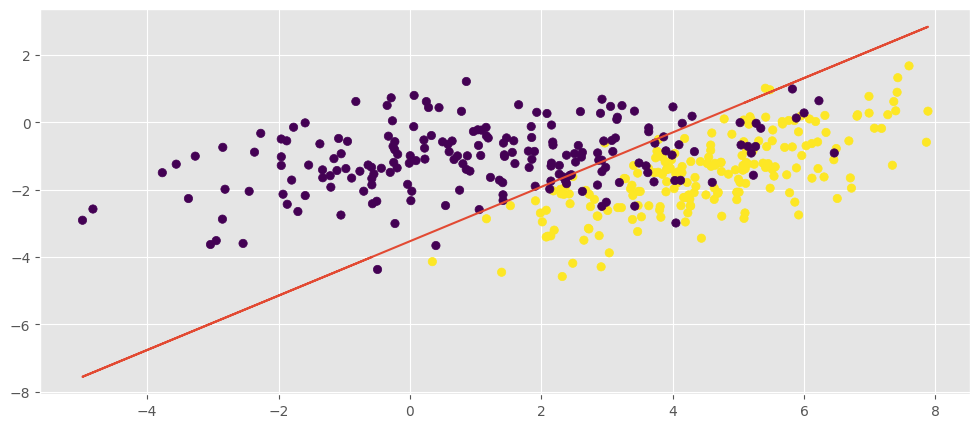

In [84]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

clf_log = MySGDClassifier(batch_generator=batch_generator, C=0.02, alpha=0.025, max_epoch=100, model_type='lin_reg')
clf_log.fit(X, y)

plot_decision_boundary(clf_log, X, y)

plt.scatter(X[:,0], X[:,1], c=y)

Далее будем анализировать Ваш алгоритм.
Для этих заданий используйте датасет ниже.

In [85]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=100000, n_features=10,
                           n_informative=4, n_redundant=0,
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)


In [86]:
clf_log = MySGDClassifier(batch_generator=batch_generator, C=0.02, alpha=0.025, max_epoch=110, model_type='log_reg')
clf_log.fit(X_train, y_train)
f1_score(y_test, clf_log.predict(X_test))

0.9710994549007508

In [87]:
clf = MySGDClassifier(batch_generator=batch_generator, C=0.02, alpha=0.025, max_epoch=100, model_type='lin_reg')
clf.fit(X_train, y_train)
f1_score(y_test, clf.predict(X_test))

0.6515406917942148

Покажите сходимости обеих регрессией на этом датасете: изобразите график  функции потерь, усредненной по $N$ шагам градиентого спуска, для разных `alpha` (размеров шага). Разные `alpha` расположите на одном графике.

$N$ можно брать 10, 50, 100 и т.д.

max_epoch = 10


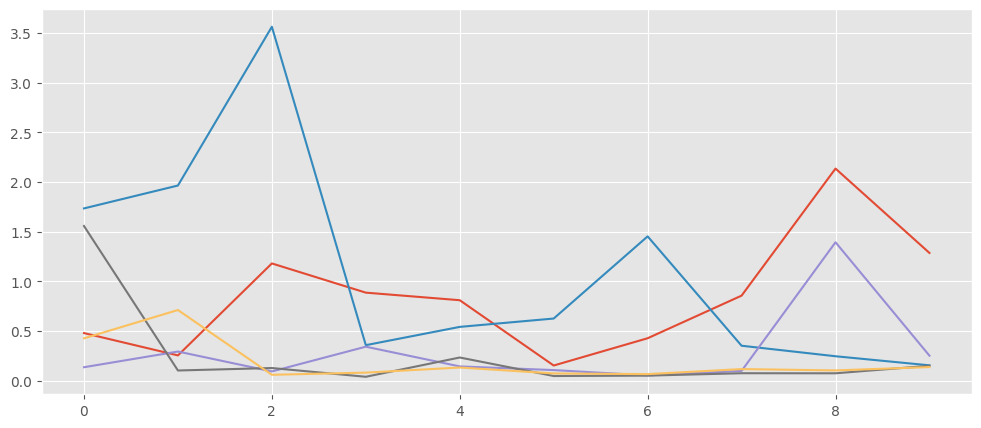

In [93]:
alpha = np.linspace(0.001, 0.1, 5)
for i in alpha:
  clf_log = MySGDClassifier(batch_generator=batch_generator, C=0.02, alpha=i, max_epoch=10, model_type='log_reg')
  clf_log.fit(X_train, y_train)
  y = clf_log.errors_log['loss'][::10]
  x = np.arange(len(y))
  plt.plot(x, y)
print('max_epoch = 10')

max_epoch = 50


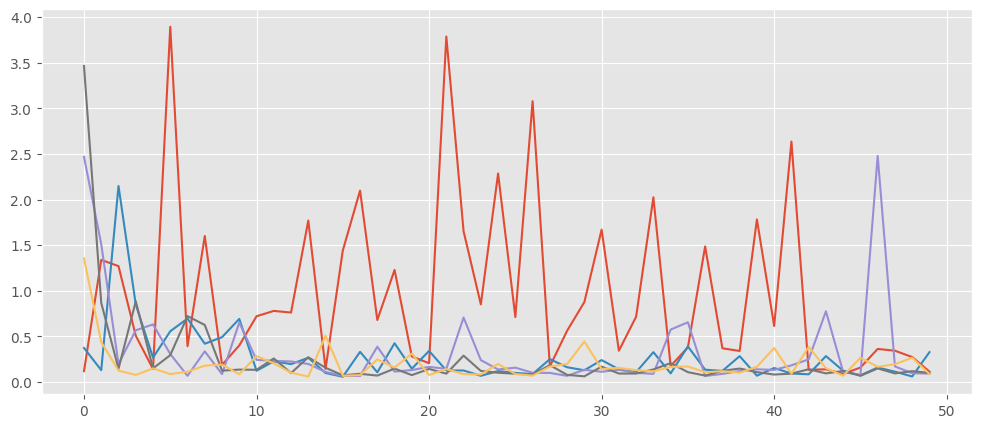

In [94]:
alpha = np.linspace(0.001, 0.1, 5)
for i in alpha:
  clf_log = MySGDClassifier(batch_generator=batch_generator, C=0.02, alpha=i, max_epoch=50, model_type='log_reg')
  clf_log.fit(X_train, y_train)
  y = clf_log.errors_log['loss'][::10]
  x = np.arange(len(y))
  plt.plot(x, y)
print('max_epoch = 50')

max_epoch = 100


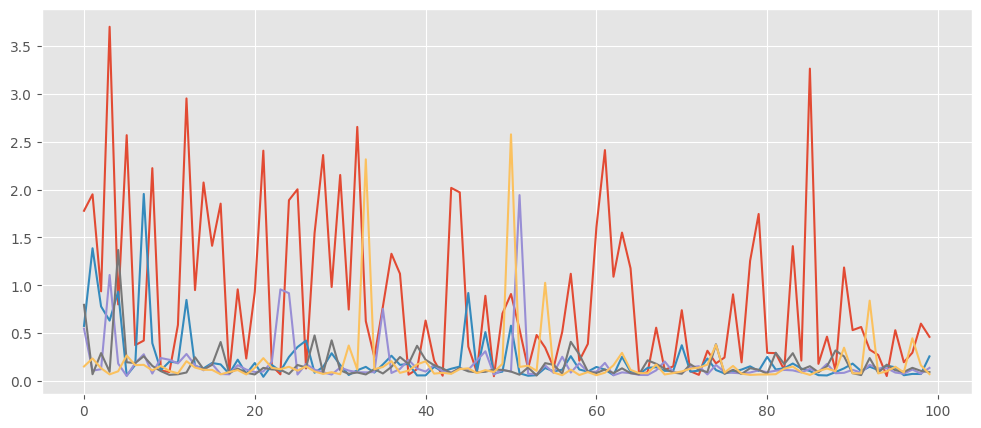

In [95]:
alpha = np.linspace(0.001, 0.1, 5)
for i in alpha:
  clf_log = MySGDClassifier(batch_generator=batch_generator, C=0.02, alpha=i, max_epoch=100, model_type='log_reg')
  clf_log.fit(X_train, y_train)
  y = clf_log.errors_log['loss'][::10]
  x = np.arange(len(y))
  plt.plot(x, y)
print('max_epoch = 100')

Что Вы можете сказать про сходимость метода при различных `alpha`? Какое значение стоит выбирать для лучшей сходимости?

Изобразите график среднего значения весов для обеих регрессий в зависимости от коеф. регуляризации С из `np.logspace(3, -3, 10)`

[ 3.          2.33333333  1.66666667  1.          0.33333333 -0.33333333
 -1.         -1.66666667 -2.33333333 -3.        ]


<ipython-input-63-fc8de151e3f9>:45: RuntimeWarning: divide by zero encountered in log
  loss = -np.mean(y_batch * np.log(log_pred) + (1 - y_batch) * np.log(1 - log_pred)) + self.C * np.dot(self.weights[1:], self.weights[1:])
<ipython-input-63-fc8de151e3f9>:45: RuntimeWarning: invalid value encountered in scalar multiply
  loss = -np.mean(y_batch * np.log(log_pred) + (1 - y_batch) * np.log(1 - log_pred)) + self.C * np.dot(self.weights[1:], self.weights[1:])
<ipython-input-63-fc8de151e3f9>:9: RuntimeWarning: overflow encountered in exp
  sigm_value_x = 1 / (1 + np.exp(-x))


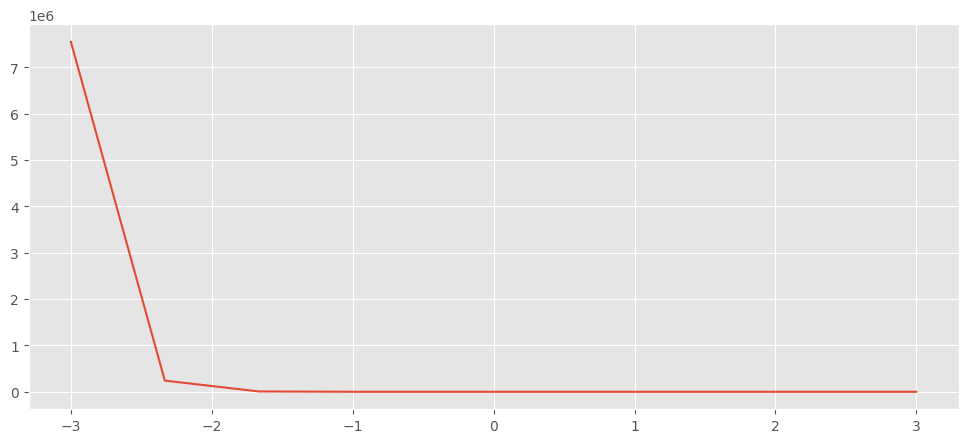

In [92]:
C = np.linspace(3, -3, 10)
print(C)
weights = []
for i in C:
  clf = MySGDClassifier(batch_generator=batch_generator, C=i, alpha=0.03, max_epoch=10, model_type='log_reg')
  clf.fit(X_train, y_train)
  weights.append(np.mean(clf.weights, axis=0))
plt.plot(C, weights)

Довольны ли Вы, насколько сильно уменьшились Ваши веса?

Да, веса сходятся в обозримо-небольшой диапазон